In [1]:
# ==============================================
# 2D Toy Example
# ==============================================

# Consider first a simple linear model y = sign(<~a,x>+~b) and norm bounded
# additive threat model. (I.e. ~a = a + delta_a | ~b = b + delta_b  with
# ||delta_a||_2 <= t_1 and ||delta_b||_2 <= t_2)

In [2]:
# --------- Imports -------------------
import numpy as np
import matplotlib.pyplot as plt
from plnn import PLNN
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import utilities as utils
import copy
import random
import time
from optimistic_adam.optim import OAdam

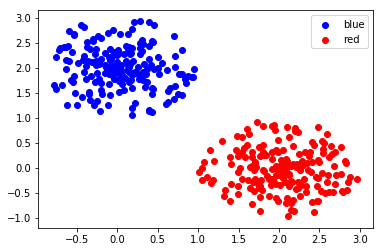

In [3]:
#---------- Load Data -----------------
# Simple, linearly seperable data plus two manually added points


def uniform_circle_samples(c, r, numpts):
    a_list = [r*np.asarray([rand_r*np.cos(theta), rand_r*np.sin(theta)]) + c for theta, rand_r
            in zip(np.random.uniform(-np.pi, np.pi, numpts), np.random.uniform(0, 1, numpts))]
    return np.asarray(a_list)
    
# Points drawn uniformly from two circles
numpts = 200
c1 = np.asarray([0,2]); c2 = np.asarray([2,0])
X1 = uniform_circle_samples(c1, 1, numpts)
X2 = uniform_circle_samples(c2, 1, numpts)

# Two manually chosen points added
epsilon = 0.05
x_red = np.asarray([0, 1-epsilon]); x_blu = np.asarray([2, 1+epsilon])
numpts2 = max(int(numpts/100), 1)
numpts2 = 0
X1_b = uniform_circle_samples(x_blu, epsilon/3, numpts2); X2_b = uniform_circle_samples(x_red, epsilon/3, numpts2)
if np.shape(X1_b)[0] > 0 and np.shape(X2_b)[0] > 0:
    X1 = np.vstack([X1, X1_b]); X2 = np.vstack([X2, X2_b])


# Create Data with Labels
X = torch.Tensor(np.vstack([X1, X2]))
y = torch.Tensor(np.hstack([np.zeros([1, np.shape(X1)[0]]), np.ones([1, np.shape(X2)[0]])])[0]).long()
X_original = copy.deepcopy(X)
y_original = copy.deepcopy(y)
numpts_total = np.shape(X)[0]
y_mod = torch.Tensor([[1, 0] if elem == 0 else [0, 1] for elem in y])

# Visualize Data
plt.scatter(X1[:,0], X1[:,1], label='blue', c='blue')
plt.scatter(X2[:,0], X2[:,1], label='red', c='red')
plt.legend()

In [4]:
#---------- Load Simple Network  -----------------
layer_sizes = [2, 2]
network = PLNN(layer_sizes)
net = network.net

# #---------- Cudaify -----------------
# net.cuda()
# X.cuda()
# y.cuda()
# y_mod.cuda()

Network Layer Sizes
[2, 2]


In [5]:
#---------- Initialize GD Method -----------------

batch_size = 2*(numpts+numpts2)
batch_size = 1

if batch_size == 1:
    numsteps = 6000
    numsteps_adv = 1000
    lr = 1e-0
elif batch_size == 2*(numpts+numpts2):
    numsteps = 4000
    numsteps_adv = 1000
    lr = 1e-0
else:
    raise NotImplementedError
    
loss_weighting = torch.Tensor(np.ones([numpts_total]))

Network Layer Sizes
[2, 2]
===============Training Network============
Elapsed Time: 6.817808389663696
final error:  tensor(0.)


C:\Users\justin\Anaconda3\lib\site-packages\torch\tensor.py:287: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


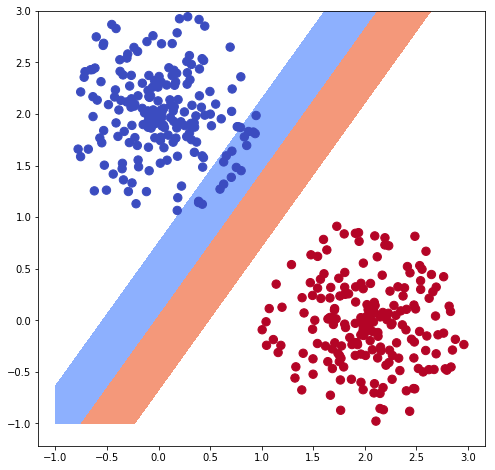

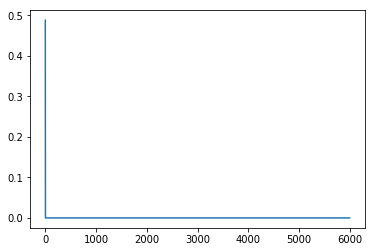

In [6]:
#---------- Train Via Gradient Descent -----------------

layer_sizes = [2, 2]
network = PLNN(layer_sizes)
net = network.net

# Train NN:
print('===============Training Network============')
errors = []
opt = optim.SGD(net.parameters(), lr=lr)
start = time.time()
for i in range(numsteps):
    indices = [elem for elem in range(0,np.shape(X)[0])]
    choices = random.sample(indices, batch_size)
    out = net(Variable(X[choices]))
    l = (nn.CrossEntropyLoss(reduction='none')(out, Variable(y[choices]))*loss_weighting).sum()
    opt.zero_grad()
    (l).backward()
    opt.step()
    out_original = net(Variable(X_original))
    y_hat = net(Variable(X)).max(1)[1].data
    y_hat_orig = out_original.max(1)[1].data
    err = (y_hat_orig != y_original).float().mean()
    errors.append(err)
print('Elapsed Time:', time.time()-start)
print('final error: ', errors[-1])

# Visualize Classifier
XX, YY = np.meshgrid(np.linspace(-1, 3, 100), np.linspace(-1, 3, 100))
X0 = Variable(torch.Tensor(np.stack([np.ravel(XX), np.ravel(YY)]).T))
y0 = net(X0)
ZZ = (y0[:,0] - y0[:,1]).resize(100, 100).data.numpy()
_, ax = plt.subplots(figsize=(8,8))
ax.contourf(XX,YY,-ZZ, cmap="coolwarm", levels=np.linspace(-1000,1000,3))
ax.scatter(X.numpy()[:,0], X.numpy()[:,1], c=y.numpy(), cmap="coolwarm", s=70)
ax.axis("equal")

# Plot Loss
xs = [i for i in range(numsteps)]
plt.figure()
plt.plot(xs, errors)

# Copy Network Weights
network_copy = copy.deepcopy(network)


In [7]:
def as_numpy(tensor_or_array):
    """ If given a tensor or numpy array returns that object cast numpy array
    """

    if isinstance(tensor_or_array, torch.Tensor):
        tensor_or_array = tensor_or_array.cpu().detach().numpy()
    return tensor_or_array

def adv_projection_step(network_copy, network, bound_ratios, norm='l2'):
    """Project current gradient on norm bounded constraints. Bound of each parameter
       given as a fraction of the norm of the original parameter (w.r.t given norm).
       Fraction value given per layer through bound_ratios"""

    if norm == 'l2':
        for fc_copy, fc, ratio in zip(network_copy.fcs, network.fcs, bound_ratios):
            for param_copy, param in zip(fc_copy.parameters(), fc.parameters()):
                param_copy_np = as_numpy(param_copy)
                diff = as_numpy(param - param_copy)
                c = ratio*np.linalg.norm(param_copy_np)/(np.linalg.norm(diff) + 1e-5)
                param.data = torch.Tensor(param_copy_np + diff*c)
    else:
        raise NotImplementedError

def net_add_random_noise(network_copy, network, bound_ratios, norm='l2'):
     for fc_copy, fc, ratio in zip(network_copy.fcs, network.fcs, bound_ratios):
            for param_copy, param in zip(fc_copy.parameters(), fc.parameters()):
                param_copy_np = as_numpy(param_copy)
                sh = np.shape(param_copy_np)
                param.data = torch.Tensor(param_copy_np + np.random.randn(np.size(param_copy_np)).reshape(sh))
                diff = as_numpy(param - param_copy)
                c = ratio*np.linalg.norm(param_copy_np)/(np.linalg.norm(diff) + 1e-5)
                param.data = torch.Tensor(param_copy_np + diff*c)

# def adv_projection_step(network_copy, network, bound_ratios, norm='l2'):
#     """Project current gradient on norm bounded constraints. Bound of each parameter
#        given as a fraction of the norm of the original parameter (w.r.t given norm).
#        Fraction value given per layer through bound_ratios"""

#     if norm == 'l2':
#         for fc_copy, fc, ratio in zip(network_copy.fcs, network.fcs, bound_ratios):
#             for param_copy, param in zip(fc_copy.parameters(), fc.parameters()):
#                 if len(np.shape(param)) > 1 :
#                     param_copy_np = as_numpy(param_copy)
#                     diff = as_numpy(param - param_copy)
#                     c = ratio*np.linalg.norm(param_copy_np)/(np.linalg.norm(diff) + 1e-5)
#                     param.data = torch.Tensor(param_copy_np + diff*c)
          
#                 else:
#                     param.data = copy.deepcopy(param_copy.data)
#     else:
#         raise NotImplementedError
    

===============Attacking Network============
Final error:  tensor(0.)


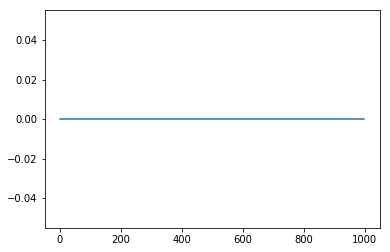

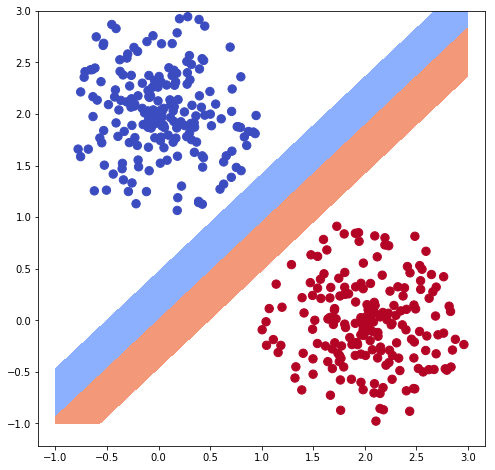

num points added: 0
===============Retraining Network============


KeyboardInterrupt: 

In [9]:
numcycles = 20
errors = []

for _ in range(0, numcycles):
    
    # --------------Attack NN--------------------:
    errors_adv = []
    print('===============Attacking Network============')
    opt = optim.Adam(net.parameters(), lr=1e-3)
    adv_power_array = [0.9, 0.9]
    for i in range(numsteps_adv):
        net_add_random_noise(network_copy, network, [0.1, 0.1])
        out_original = net(Variable(X_original))
        l = -1*nn.CrossEntropyLoss()(out_original, Variable(y_original))
        opt.zero_grad()
        (l).backward()
        opt.step()
        if i % 100 == 0 or i == numsteps_adv -1:
            adv_projection_step(network_copy, network, adv_power_array)
        y_hat_adv = net(Variable(X)).max(1)[1].data
        y_hat_orig = out_original.max(1)[1].data
        err = (y_hat_orig != y_original).float().mean()
        errors.append(err)
        errors_adv.append(err)
    print('Final error: ', err)
    plt.figure()
    plt.plot([_ for _ in range(0, len(errors_adv))], errors_adv)
    plt.show()
    
    # Visualize Classifier
    XX, YY = np.meshgrid(np.linspace(-1, 3, 100), np.linspace(-1, 3, 100))
    X0 = Variable(torch.Tensor(np.stack([np.ravel(XX), np.ravel(YY)]).T))
    y0 = net(X0)
    ZZ = (y0[:,0] - y0[:,1]).resize(100, 100).data.numpy()
    _, ax = plt.subplots(figsize=(8,8))
    ax.contourf(XX,YY,-ZZ, cmap="coolwarm", levels=np.linspace(-1000,1000,3))
    ax.scatter(X.numpy()[:,0], X.numpy()[:,1], c=y.numpy(), cmap="coolwarm", s=70)
    ax.axis("equal")
    plt.show()
    
    #---------- Reweight Points -----------------
    # some points originally correclty classified, now wrong are made more important:
#     correct_indices = [index for index in range(0, np.shape(X)[0]) if y[index] == y_hat[index]]
#     now_misclass_indices = [index for index in correct_indices if y_hat[index] != y_hat_adv[index]]
    now_misclass_indices = [index for index in range(0, np.shape(X)[0]) if y[index] != y_hat_adv[index]]
    print('num points added:', len(now_misclass_indices))
#     num_to_add = 100
#     loss_weighting_new = [w + num_to_add if index in now_misclass_indices else w for index, w in enumerate(loss_weighting)]
#     loss_weighting_new = torch.Tensor(np.multiply(loss_weighting_new, numpts_total/np.sum(loss_weighting_new)))

    # ------ Add points instead of reweighting --------
    X_np = utils.as_numpy(X)
    Xadd = utils.as_numpy(X_np[now_misclass_indices])
    X = torch.Tensor(np.vstack([X_np, Xadd]))
    
    y_np = utils.as_numpy(y)
    yadd = utils.as_numpy(y_np[now_misclass_indices])
    y = torch.Tensor(np.hstack([y_np, yadd])).long()
    

    #---------- Retrain -----------------

    # Train NN:
    errors_train = []
    opt2 = optim.Adam(net.parameters(), lr=lr)
    print('===============Retraining Network============')
    player_power_array = [1.0, 1.0]
    start = time.time()
    for i in range(numsteps):
        indices = [elem for elem in range(0,np.shape(X)[0])]
        choices = random.sample(indices, batch_size)
        out = net(Variable(X[choices]))
        #TODO: change back to loss_weighting
        opt2.zero_grad()
        l = nn.CrossEntropyLoss()(out, Variable(y[choices]))
        (l).backward()
        opt2.step()
        adv_projection_step(network_copy, network, player_power_array)
        out_original = net(Variable(X_original))
        y_hat = net(Variable(X)).max(1)[1].data
        y_hat_orig = out_original.max(1)[1].data
        err = (y_hat_orig != y_original).float().mean()
        errors.append(err)
        err = (y_hat != y).float().mean()
        errors_train.append(err)
    print('Final error: ', err)
    plt.figure()
    plt.plot([_ for _ in range(0, len(errors_train))], errors_train)
    plt.show()
    
    # Visualize Classifier
    XX, YY = np.meshgrid(np.linspace(-1, 3, 100), np.linspace(-1, 3, 100))
    X0 = Variable(torch.Tensor(np.stack([np.ravel(XX), np.ravel(YY)]).T))
    y0 = net(X0)
    ZZ = (y0[:,0] - y0[:,1]).resize(100, 100).data.numpy()
    _, ax = plt.subplots(figsize=(8,8))
    ax.contourf(XX,YY,-ZZ, cmap="coolwarm", levels=np.linspace(-1000,1000,3))
    ax.scatter(X.numpy()[:,0], X.numpy()[:,1], c=y.numpy(), cmap="coolwarm", s=70)
    ax.axis("equal")

    
    print('num_pts:', np.shape(X)[0])
    plt.figure()
    plt.plot([_ for _ in range(0, len(errors))], errors)
    plt.show()



In [ ]:
for fc_copy, fc in zip(network_copy.fcs, network.fcs):
    for param_copy, param in zip(fc_copy.parameters(), fc.parameters()):
        print(param.data)